In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#! pip install mosestokenizer

In [3]:
# colab　にmecabを入れる
#!apt install aptitude
#!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
#!pip install mecab-python3==0.7

In [4]:
import sys
import gc
import os
#base_dir = "drive/My Drive/jp_en_translation/".replace("/",os.sep)
base_dir = "../"
emb_dir = "drive/My Drive/util_data/".replace("/",os.sep)
sys.path.append("/Users/ueki/Desktop/work/jp_en_translation")
sys.path.append("/Users/ueki/Desktop/JP_EN_Transalation")
sys.path.append(base_dir)
sys.path.append("drive/My Drive/jp_en_translation".replace("/",os.sep))

In [5]:
from models.Seq2Seq_attention import Seq2Seq
from utils.LangEn import LangEn
from utils.LangJa import LangJa
from utils.build_emb import build_en_emb,build_jp_emb
from utils.preprocess import loadLangs
import numpy as np
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import torch

Using TensorFlow backend.


In [6]:
config={
    "corpus_file":base_dir+"data/jpn.txt",
    "en_col":"description_en",
    "jp_col":"description_jp",
    "mask_token":0,
    "SOS_token":1,
    "EOS_token":2,
    "UNK_token":3,
    "max_features":8000,
    "MAX_LENGTH":20,
    "train_size":5000,
    "val_size":300,
    "batch_size":1024,
    "epochs":3,
    "maxlen_enc":20,
    "maxlen_dec":20,
    "n_hidden":300,
    "input_dim":5000,
    "jp_voc":8000,
    "en_voc":5000,
    "output_dim":8000,
    "emb_dim":300,
    "use_enc_emb":False,
    "use_dec_emb":False,
    "validation_split":0.01,
    "trained_param_dir":base_dir+"trained_models/1_lstm_ja_en_01.hdf5",
    "translate_length":25,
    "en_W2V_FILE" : emb_dir+"GoogleNews-vectors-negative300.bin.gz",
    "jp_W2V_FILE":emb_dir+"ja_data/ja.bin",
    "src":"en",
    "trg":"jp",
    "learning_rate":0.01,
}

# train

In [7]:
data=loadLangs(config)

reading lines


In [8]:
val_data = data[config["train_size"]:config["train_size"]+config["val_size"]]
data = data[:config["train_size"]]

In [9]:
EN_lang = LangEn(config)
JP_lang = LangJa(config)

W0806 17:52:27.151748 4712236480 toolwrapper.py:77] stdbuf was not found; communication with perl may hang due to stdio buffering.


In [10]:
for s in data[config["en_col"]]:
    EN_lang.addSentence(s)

In [11]:
for s in data[config["jp_col"]]:
    JP_lang.addSentence(s)

## input の加工

In [12]:
if config["src"]=="jp":
    src_col=config["jp_col"]
    trg_col=config["en_col"]
    Langs={"src":JP_lang,"trg":EN_lang}
else:
    src_col=config["en_col"]
    trg_col=config["jp_col"]
    Langs={"trg":JP_lang,"src":EN_lang}

In [13]:
input_en = data[src_col]

In [14]:
input_source_lang=data[src_col].apply(lambda x:Langs["src"].word2id(x))
input_target_lang=data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [15]:
val_source = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))
val_target = val_data[trg_col].apply(lambda x:Langs["trg"].word2id(x))

In [16]:
input_source_padded=sequence.pad_sequences(input_source_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
input_target_padded=sequence.pad_sequences(input_target_lang,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [17]:
val_source_padded=sequence.pad_sequences(val_source,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")
val_target_padded=sequence.pad_sequences(val_target,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [18]:
input_source_padded[10]

array([51, 57, 58, 43, 59, 60, 61, 28, 62,  6,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

In [19]:
input_target_padded[10]

array([32, 23, 63, 40, 27, 64, 65, 10, 66, 12, 67,  6,  2,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## create embedding

In [21]:
#en_emb = build_en_emb(config,EN_lang.word2index)

In [22]:
#ja_emb = build_jp_emb(config,JP_lang.word2index)

In [23]:
#if config["src"]=="en":
#    emb={"src_emb":en_emb,"trg_emb":ja_emb}
#else:
  #  emb={"src_emb":ja_emb,"trg_emb":en_emb}

In [24]:
#print("enc->",emb["trg_emb"].shape)
#print("dec->",emb["src_emb"].shape)

In [25]:
#trainer = Seq2Seq(config,enc_emb=emb["src_emb"],dec_emb=emb["trg_emb"])
trainer = Seq2Seq(config)

train_size:5000 - val_size:300
Epoch 1/3
102 - loss: 0.17903 - val-loss: 0.58781
----------------
Epoch 2/3
112 - loss: 0.17018 - val-loss: 0.45270
----------------
Epoch 3/3
112 - loss: 0.14707 - val-loss: 0.46674
----------------


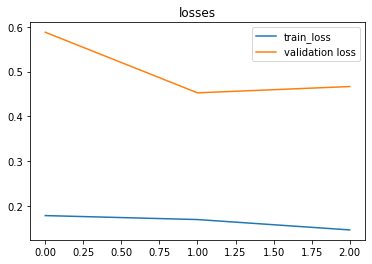

In [26]:
trainer.trainIters(input_source_padded,input_target_padded,val_source_padded,val_target_padded)

# test

In [27]:
val_data_id = val_data[src_col].apply(lambda x:Langs["src"].word2id(x))

In [28]:
val_padded=sequence.pad_sequences(val_data_id,maxlen=config["MAX_LENGTH"],padding="post",truncating="post")

In [29]:
ret=[]
for s in val_padded:
    ret.append(trainer.translate(s))

In [30]:
for src,pred,target in zip(val_data[src_col],ret,val_data[trg_col]):
    print("src->",src)
    print()
    print("pred->"," ".join(Langs["trg"].id2word(pred)))
    print("ans->",target)
    print("------------------")

src-> i have never eaten a mango before.

pred-> EOS
ans-> 今 まで に 一 度 も マンゴー を 食べ た こと が あり ませ ん 。
------------------
src-> i met him at toms house.

pred-> EOS
ans-> トム の 家 で 彼 に 会い まし た 。
------------------
src-> you cant live without water.

pred-> EOS
ans-> 水 なし で は 生き られ ない 。
------------------
src-> what time are you going to leave for london?

pred-> EOS
ans-> あなた は 何 時 に ロンドン へ 向け て 出発 する 予定 です か 。
------------------
src-> mt. everest is the highest mountain in the world.

pred-> EOS
ans-> エベレスト は 世界 で 最も 高い 山 です 。
------------------
src-> for example do you like english?

pred-> EOS
ans-> 例えば 、 君 は 英語 が 好き です か 。
------------------
src-> i found it pretty hard to adjust to my new surroundings.

pred-> EOS
ans-> 新しい 環境 に 順応 する の は かなり 大変 な 事 だ と わかっ た 。
------------------
src-> when did you come to japan?

pred-> EOS
ans-> い つ 日本 に いらっしゃっ た ん です か 。
------------------
src-> this isnt important.

pred-> EOS
ans-> これ は 重要 で は ない 。
------------------
src-> spring will be here soon

pred-> EOS
ans-> バス で なく て 列車 で 行き ましょ う 。
------------------
src-> i agree with you.

pred-> EOS
ans-> 同感 です 。
------------------
src-> she stood close to her husband.

pred-> EOS
ans-> 彼女 は 夫 の そば に ぴったり 寄り添っ て い た 。
------------------
src-> i wont be quiet.

pred-> EOS
ans-> 僕 は 黙ら ない ぞ 。
------------------
src-> everything is ready.

pred-> EOS
ans-> 準備 完了 ！
------------------
src-> blood pressure is important as a barometer of health.

pred-> EOS
ans-> 血圧 は 健康 の バロメーター として 重要 で ある 。
------------------
src-> she trembled with fear.

pred-> EOS
ans-> 彼女 は 恐ろしく て 身震い し た 。
------------------
src-> i hear my uncle died of cancer.

pred-> EOS
ans-> 叔父 の 死因 は 癌 だっ た そう です 。
------------------
src-> tom cried.

pred-> EOS
ans-> トム は 涙 を 流し た 。
------------------
src-> ill see you at nine tomorrow morning.

pred-> EOS
ans-> 明朝 ９ 時 に お 会い し ましょ う 。
------------------
src-> i am a college student.

pred-> EOS
ans-> 大学生 です 。
------------------
src-> he was the king of rockandroll.

pred-> EO